# Resources and credit:
- SSDD data download: https://github.com/TianwenZhang0825/LS-SSDD-v1.0-OPEN
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html

# Installation of detectron2 and Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

     |████████████████████████████████| 274 kB 5.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=64865615a3085cd564e34c5678539c2f796843273f128155053fe7b5cd556284
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.9.0+cu111 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
#assert torch.__version__.startswith("1.7")

!pip install 'git+https://github.com/facebookresearch/detectron2.git'
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-xobvv8k8
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-xobvv8k8
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5565693 sha256=05d35568bb2f8f92899337840ab2f7657532bafd1af8a45b331e547254020f21
  Stored in directory: /tmp/pip-ephem-wheel-cache-7o25o7q6/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
Successfully built detectron2
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.5+cu101
    Uninstalling detectron2-0.5+cu101:
      Successfully uninstalled detectron2-0.5+cu101


In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Registration of the custom dataset to detectron2

In [9]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [10]:
# Global paths
datasets = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/datasets/'

# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from detectron2.structures import BoxMode

pre = 'ssdd_'

# Register
for d in ["train", "test", "test_offshore", "test_inshore"]:
    DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

In [5]:
# Instances of metadata
train_metadata = MetadataCatalog.get(pre + 'train')
test_metadata = MetadataCatalog.get(pre + 'test')
test_offshore_metadata = MetadataCatalog.get(pre + 'test_offshore')
test_inshore_metadata = MetadataCatalog.get(pre + 'test_inshore')

# Training on a custom dataset
*Change Runtime to GPU before running*

In [11]:
%cd /content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/
output = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/'
model_name = "./ModelOutput/retinanet_R_101_FPN_3x_1"

/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD


In [12]:
!pwd

/content/drive/My Drive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD


In [13]:
from detectron2.engine import DefaultTrainer
# model zoo - https://github.com/facebookresearch/detectron2/tree/master/configs/COCO-Detection
# detectron2.config - https://detectron2.readthedocs.io/en/latest/modules/config.html

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (pre + "train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.MAX_ITER = 30000   # 36000/72000  # 10 epochs * 6000 images / 2 images per batch = 30,000 iterations
cfg.MODEL.RETINANET.NUM_CLASSES = 1   # only has one class (ship). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # allows training examples without annotations

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [14]:
cfg.OUTPUT_DIR = model_name
cfg.OUTPUT_DIR

'./ModelOutput/retinanet_R_101_FPN_3x_1'

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/08 11:14:21 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_971ab9.pkl: 228MB [00:08, 27.4MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
head.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


[11/08 11:15:04 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[11/08 11:15:34 d2.utils.events]:  eta: 12:33:11  iter: 19  total_loss: 0.01587  loss_cls: 0.01587  loss_box_reg: 0  time: 1.4615  data_time: 0.0269  lr: 4.9953e-06  max_mem: 2207M
[11/08 11:16:03 d2.utils.events]:  eta: 12:25:54  iter: 39  total_loss: 0.03898  loss_cls: 0.03898  loss_box_reg: 0  time: 1.4574  data_time: 0.0045  lr: 9.9902e-06  max_mem: 2207M
[11/08 11:16:33 d2.utils.events]:  eta: 12:23:41  iter: 59  total_loss: 0.03781  loss_cls: 0.03781  loss_box_reg: 0  time: 1.4637  data_time: 0.0049  lr: 1.4985e-05  max_mem: 2207M
[11/08 11:17:03 d2.utils.events]:  eta: 12:28:09  iter: 79  total_loss: 0.07912  loss_cls: 0.07912  loss_box_reg: 0  time: 1.4706  data_time: 0.0046  lr: 1.998e-05  max_mem: 2207M
[11/08 11:17:31 d2.utils.events]:  eta: 12:23:14  iter: 99  total_loss: 0.06662  loss_cls: 0.06662  loss_box_reg: 0  time: 1.4593  data_time: 0.0048  lr: 2.4975e-05  max_mem: 2220M
[11/08 11:18:00 d2.utils.events]:  eta: 12:22:12  iter: 119  total_loss: 0.09679  loss_cls: 0.09

# TensorBoard

In [ ]:
# Look at training curves in tensorboard:
%cd ModelOutput/
%load_ext tensorboard
%tensorboard --logdir retinanet_R_101_FPN_3x_1
%cd ..

# Evaluation using the trained model

To run inference using the trained model on the validation/test dataset, we first create a predictor using the model we just trained.

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5   # 0.7
#cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5   # pg. 23 of Zhang et al.

predictor = DefaultPredictor(cfg)

## Visualization

We randomly select several samples to visualize the prediction results.

In [ ]:
#from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_dict("test")   # must be "test", "test_offshore", "test_inshore"

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

In [ ]:
def printImage(ann, metadata, predictor = None, predFlag = False):
  #from detectron2.utils.visualizer import Visualizer

  im = cv2.imread(ann["file_name"])
  v = Visualizer(im[:, :, ::-1], 
                 metadata=metadata, 
                 scale=0.5)
  
  if predFlag:
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  else:
    out = v.draw_dataset_dict(ann)
  
  image = out.get_image()[:, :, ::-1]

  return image

In [ ]:
os.makedirs(model_name + "/predImages", exist_ok=True)  # Make a directory for output images

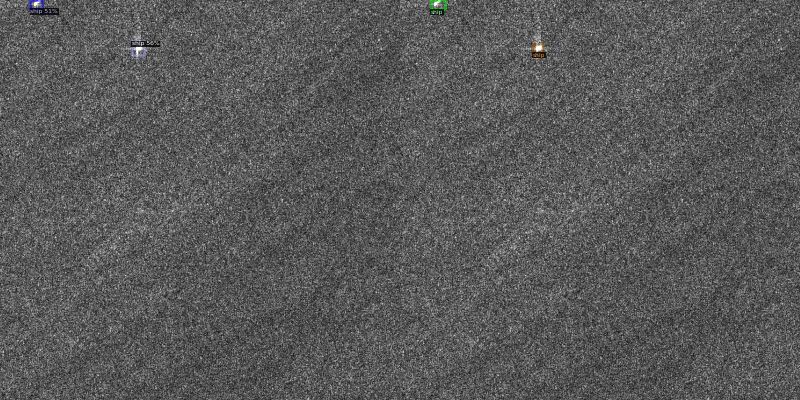

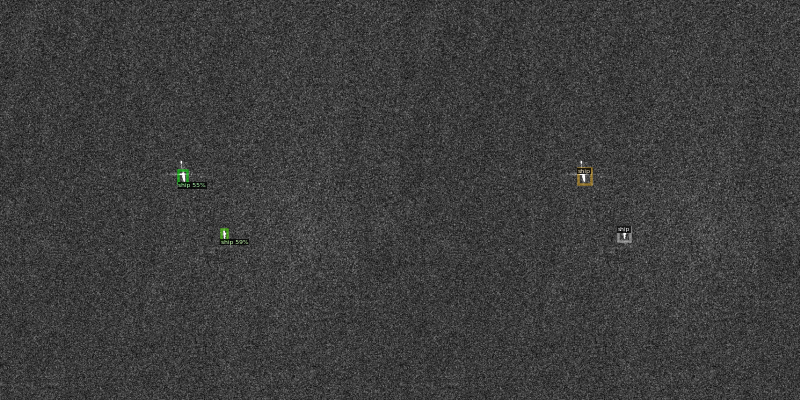

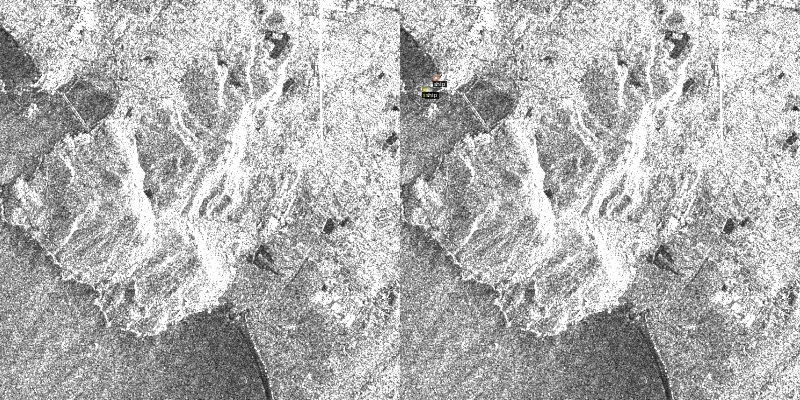

In [ ]:
from cv2 import hconcat
#random.seed(2)

num_samples = 3

for d in random.sample(dataset_dicts_anns, num_samples):
  image1 = printImage(d, test_metadata, predictor, True)  # Prediction
  image2 = printImage(d, test_metadata, False)  # Ground truth
  image3 = hconcat([image1, image2])

  cv2_imshow(image3)  # display an image
  cv2.imwrite(model_name + '/predImages/' + str(d["image_id"] + '.jpg'), image3)  # save an image

# Prediction

We can also evaluate its performance using AP metric implemented in COCO API.

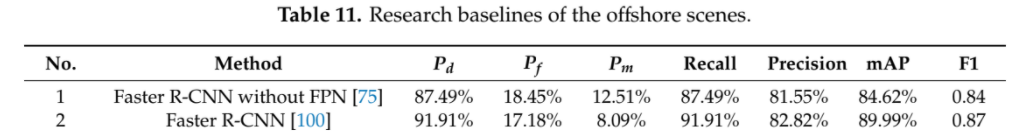

In [ ]:
#val = './datasets/test/'

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# test_offshore
evaluator = COCOEvaluator('ssdd_test_offshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_offshore')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[01/27 03:27:44 d2.evaluation.coco_evaluation]: 'ssdd_test_offshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[01/27 03:27:44 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test_offshore' to COCO format ...)
[01/27 03:28:10 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/27 03:28:10 d2.data.datasets.coco]: Conversion finished, #images: 2234, #annotations: 1495
[01/27 03:28:10 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/retinanet_R_101_FPN_3x_1/ssdd_test_offshore_coco_format.json' ...
[01/27 03:28:11 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 1495         |
|            |              |
[01/27 03:28:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/

In [ ]:
# test
evaluator = COCOEvaluator('ssdd_test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[01/27 03:34:33 d2.evaluation.coco_evaluation]: 'ssdd_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[01/27 03:34:33 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test' to COCO format ...)
[01/27 03:34:33 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/27 03:34:34 d2.data.datasets.coco]: Conversion finished, #images: 3000, #annotations: 2378
[01/27 03:34:34 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/retinanet_R_101_FPN_3x_1/ssdd_test_coco_format.json' ...
[01/27 03:34:34 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 2378         |
|            |              |
[01/27 03:34:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/27 03:34:34 d2.data.common]

In [ ]:
# test_inshore
evaluator = COCOEvaluator('ssdd_test_inshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_inshore')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[01/27 03:42:21 d2.evaluation.coco_evaluation]: 'ssdd_test_inshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[01/27 03:42:21 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test_inshore' to COCO format ...)
[01/27 03:42:27 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/27 03:42:27 d2.data.datasets.coco]: Conversion finished, #images: 766, #annotations: 883
[01/27 03:42:27 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/retinanet_R_101_FPN_3x_1/ssdd_test_inshore_coco_format.json' ...
[01/27 03:42:27 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 883          |
|            |              |
[01/27 03:42:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/27 03

In [ ]:
%ls ./ModelOutput/retinanet_R_101_FPN_3x_1

ls: cannot access './ModelOutput/retinanet_R_101_FPN_3x_1': No such file or directory
